In [42]:
import pytest
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
mi.set_variant('scalar_spectral')

In [77]:
b = mi.load_dict({'type': 'diffuse',
                  'reflectance': {
                      'type': 'regular',
                      'wavelength_min': 600,
                      'wavelength_max': 700,
                      'values': '0.3, 0.7',
                  }
                  })  # load diffuse BSDF


print(f'b.component_count()\t= {b.component_count()}')
print(f'b.flags(0)\t\t= {b.flags(0)}')
print(f'b.flags()\t\t= {b.flags()}')
print(f'mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide =\
 {mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide}')

# how to check the flags of a BSDF:
assert b.flags(0) == mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide

print(f'\nInformation about BSDF b:\n{b}')


b.component_count()	= 1
b.flags(0)		= 32770
b.flags()		= 32770
mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide = 32770

Information about BSDF b:
SmoothDiffuse[
  reflectance = RegularSpectrum[
    distr = ContinuousDistribution[
      size = 2,
      range = [600, 700],
      integral = 50,
      pdf = [0.3, 0.7]
    ]
  ]
]


In [78]:
bsdf = mi.load_dict({'type': 'diffuse'}) # create BSDF

si = mi.SurfaceInteraction3f() # create SurfaceInteraction
si.p = [0, 0, 0] # Position in world coordinates
si.n = [0, 0, 1] # Surface normal pointing in z direction
si.wi = [0, 0, 1] # incident direction in local shading frame

ctx = mi.BSDFContext()

n = 20 # number of samples
thetas = np.linspace(start=0, stop=dr.pi/2, num=n) # incident angles from 0 to 90 degrees
v_pdf_all = np.linspace(0, 0, n) # array for pdf values

for i in range(n):
    theta = i / (n-1) * (dr.pi / 2)  # incident angles from 0 to 90 degrees
    wo = [dr.sin(theta), 0, dr.cos(theta)] # outgoing direction in local shading frame starting at 0 degrees (parallel to surface normal) and going to 90 degrees (parallel to x-axis) 

    # evaluate pdf at given incident and outgoing direction
    # bsdf.pdf() returns a scalar value
    v_pdf  = bsdf.pdf(ctx, si=si, wo=wo) 
    assert dr.allclose(v_pdf, wo[2] / dr.pi)

    # Evaluate the BSDF f(wi, wo) and multiply by the cosine foreshortening term
    # bsdf.eval() returns a spectrum
    v_eval = bsdf.eval(ctx, si=si, wo=wo) 
    assert dr.allclose(v_eval, 0.5 * wo[2] / dr.pi)

    # Evaluate the BSDF f(wi, wo) and multiply by the cosine foreshortening term
    # bsdf.eval_pdf() returns the tuple (bsdf.eval, bsdf.pdf)
    v_eval_pdf = bsdf.eval_pdf(ctx, si=si, wo=wo) 
    assert dr.allclose(v_eval, v_eval_pdf[0])
    assert dr.allclose(v_pdf, v_eval_pdf[1])
    
    # print(f'incident angle:\t{theta*180/dr.pi}°')
    # print(f'v_pdf:\t\t{v_pdf} \nv_eval:\t\t{v_eval}\nv_eval_pdf:\t{v_eval_pdf}\n')
    
    v_pdf_all[i] = v_pdf # store pdf value

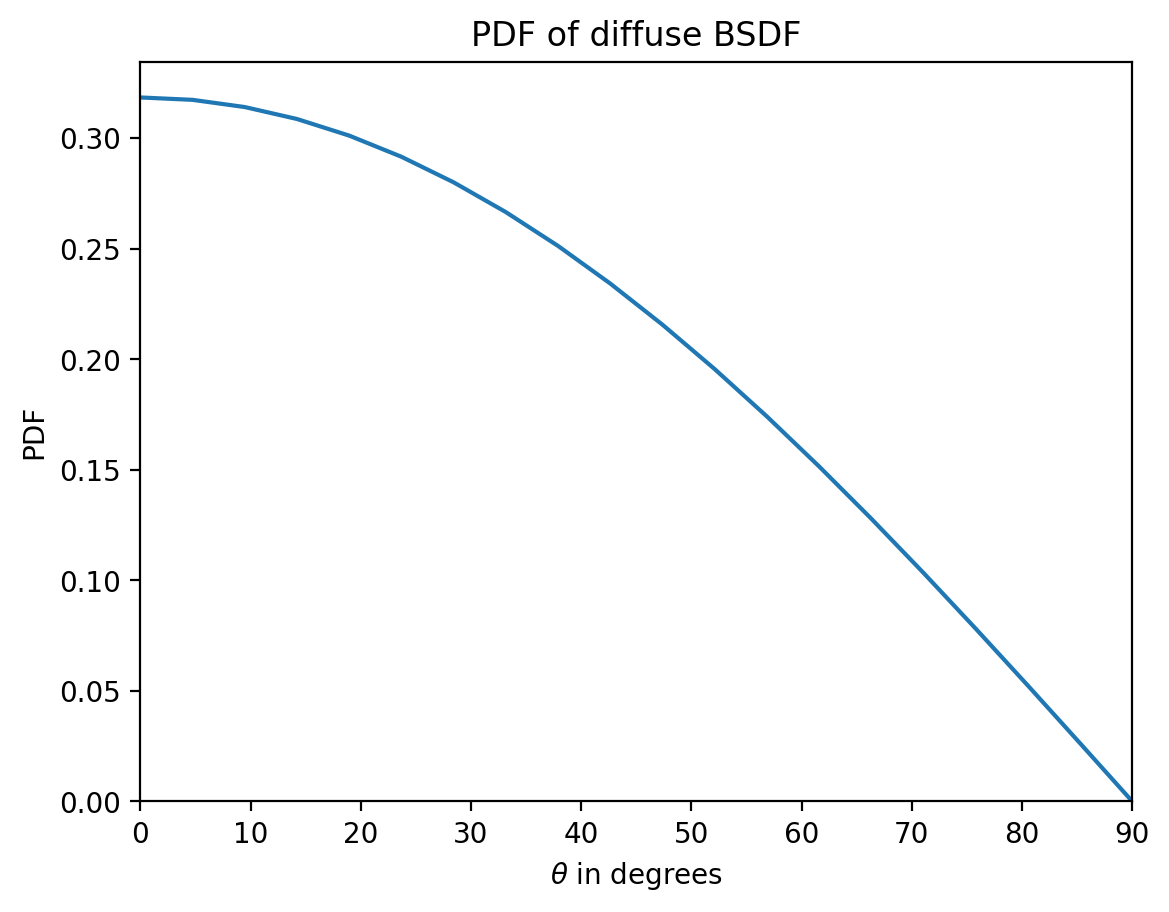

In [49]:
# Plot PDF of diffuse BSDF:
plt.figure()
plt.plot(thetas/dr.pi*180, v_pdf_all)
plt.xlabel(r'$\theta$ in degrees')
plt.xlim([0, 90])
plt.ylim(bottom=0)
plt.title('PDF of diffuse BSDF')
plt.ylabel('PDF');